# Demonstration of Basic Neuro Models

In [17]:
import numpy as np
import scipy.io as sio
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sys

sys.path.append('../neural')

from neuron import *
from plot import plot_multiple
from utils import generate_stimulus

Define input stimulus.

In [21]:
dt  = 1e-5
dur = 0.2

waveform = generate_stimulus('step', dt, dur-dt/2, (0.05, 0.15), 20.)
t = np.arange(0, len(waveform)*dt-dt/2, dt)

In [ ]:
Simulate e

In [15]:
model_list = [IAF, LeakyIAF, HodgkinHuxley, Wilson, Rinzel, ConnorStevens]
record = {key:np.zeros(len(waveform)) for key in model_list}

for M in model_list:
    model = M()
    for i, wav in enumerate(waveform):
        model.update(dt, wav)
        record[M][i] = model.v

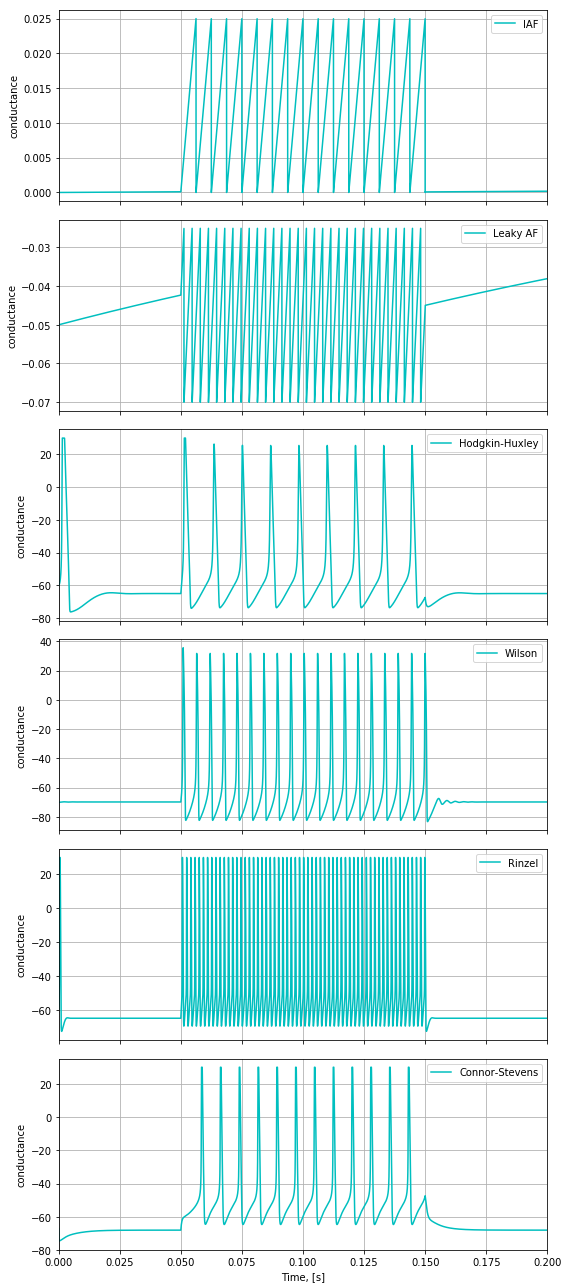

In [16]:
fig, axes = plot_multiple(
    t,
    (record[IAF], {'color':'c', 'label':'IAF'}),
    (record[LeakyIAF], {'color':'c', 'label':'Leaky AF'}),
    (record[HodgkinHuxley], {'color':'c', 'label':'Hodgkin-Huxley'}),
    (record[Wilson], {'color':'c', 'label':'Wilson'}),
    (record[Rinzel], {'color':'c', 'label':'Rinzel'}),
    (record[ConnorStevens], {'color':'c', 'label':'Connor-Stevens'}),
    xlim=(0,dur), figw=8, figh=3, ylabel='conductance')